##Recognizing ASL Fingerspelling Using Machine Learning
####Dataset Name: ASL Alphabet
####[Kaggle Data Soruce](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
####Goal: Develop a machine learning model to recognize ASL fingerspelling from images.

####Dataset Overview:
- American Sign Language alphabet dataset from Kaggle
- Contains 87,000 training images across 29 classes
- 26 classes represent letters A-Z and 3 additional classes

###Dataset Characteristics:
- Images show hand gestures against backgrounds
- Images 200x200 pixels
- Each image shows static hand position corresponding to a letter

###Class Selection:
- Despite having 29 classes in the full dataset, our analysis focuses on 18 letters

###The Objective
- To accurately classify ASL alphabet images into their respective letter classes

In [258]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [259]:
dataset_path = "./asl_alphabet_data"

In [260]:
#grabs all the folder names in the dataset and sorts them
all_classes = sorted([os.path.basename(folder) for folder in glob.glob(os.path.join(dataset_path, "*"))])

def print_classes(title, class_list, rows, cols):
    #prints the title along with the number of items in the class list
    print(f"{title}: {len(class_list)}")
    #prints a header for the dataset classes
    print("\nDataset Classes:")
    index = 0 #keep track of the current position
    for row in range(rows):
        row_classes = [] #stores the items for the current row
        for col in range(cols):
            row_classes.append(class_list[index]) #adds the class name to the row list
            index += 1 #moves to the next class in the list
        print(" | ".join(row_classes)) #prints the row

#calls print_class function
print_classes("Total Dataset Classes", all_classes, 3, 9)

Total Dataset Classes: 27

Dataset Classes:
A | B | C | D | E | F | G | H | I
J | K | L | M | N | O | P | Q | R
S | T | U | V | W | X | Y | Z | nothing


---
###Selected Letters 

I'm picking a smaller set of ASL letters to make the dataset easier to work with and keep things running smoothly on my computer. Some letters, like "J" and "Z," need movement to sign, so they don’t work as well with static images.

In [262]:
#list of ASL letters we selected for this project
asl_keep = ["A", "B", "C", "D", "E", "F", "H", "I", "L", "O", "Q", "R", "S", "U", "V", "W", "X", "Y"]

#calls print_class function
print_classes("Selected ASL Letters", asl_keep, 2, 9)

Selected ASL Letters: 18

Dataset Classes:
A | B | C | D | E | F | H | I | L
O | Q | R | S | U | V | W | X | Y


In [263]:
#list to store image file paths for selected asl letters
asl_paths_train = []

for letter in asl_keep:
    #creates the full path to the letters folder
    letter_path = os.path.join(dataset_path, letter)
    #grabs all jpg images inside the letters folders
    letter_images = glob.glob(os.path.join(letter_path, "*.jpg"))
    #adds up to 500 images from this letter to the training list
    asl_paths_train.extend(letter_images[:500])

#extracts the letter label from each image
asl_labels_train = [os.path.basename(os.path.dirname(img)) for img in asl_paths_train]

#creates a df with the image paths and their labels
train_asl_df = pd.DataFrame({"image_path": asl_paths_train, "letter_label": asl_labels_train})

#prints total number of images added to the dataset
print(f"\nTotal images loaded: {len(train_asl_df)}")
#counts how many images belong to each letter
class_distribution = train_asl_df['letter_label'].value_counts()
#sort alphabetically instead of by count
class_distribution = class_distribution.sort_index()

#prints a breakdwon of how many images there are per class
print("\nImages per class:")
print("-" * 20)
for letter, count in class_distribution.items():
    print(f"Letter {letter}: {count:4d} images")
print("-" * 20)


Total images loaded: 9000

Images per class:
--------------------
Letter A:  500 images
Letter B:  500 images
Letter C:  500 images
Letter D:  500 images
Letter E:  500 images
Letter F:  500 images
Letter H:  500 images
Letter I:  500 images
Letter L:  500 images
Letter O:  500 images
Letter Q:  500 images
Letter R:  500 images
Letter S:  500 images
Letter U:  500 images
Letter V:  500 images
Letter W:  500 images
Letter X:  500 images
Letter Y:  500 images
--------------------


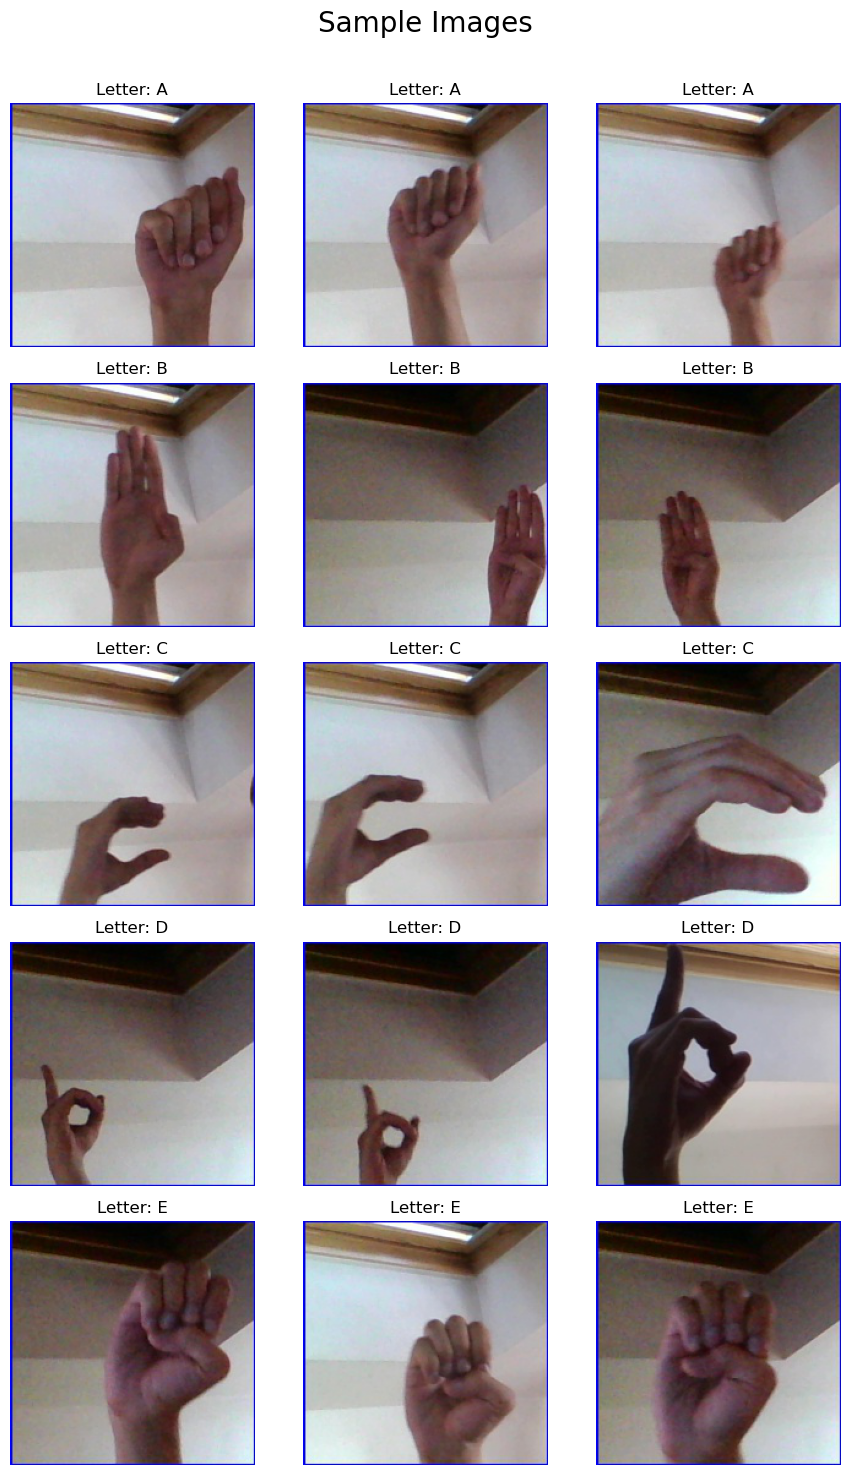

In [264]:
#display a grid of sample images for letters
letters = asl_keep[:5]
samples_per_letter = 3

#creates a grid of subplots on the number of letter and samples per letter
rows = len(letters)
cols = samples_per_letter
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))


for i, letter in enumerate(letters):
    #randomly selects the specified number of images for this letter
    letter_samples = train_asl_df[train_asl_df['letter_label'] == letter].sample(samples_per_letter)
    
    for j, (_, row) in enumerate(letter_samples.iterrows()):
        #load the image from its file path
        img = plt.imread(row['image_path'])
        #displays the image in the corresponding subplit
        axes[i, j].imshow(img)
        #sets the title above each image with the letter label
        axes[i, j].set_title(f"Letter: {letter}")
        #removes axis markings
        axes[i, j].axis('off')
        
        for spine in axes[i, j].spines.values():
            #adds a border around each image  
            spine.set_visible(True)
            spine.set_color('gray')
            spine.set_linewidth(0.5)

#sets the overall title for the entire gird
plt.suptitle("Sample Images", fontsize=20)
#adjusts the layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.97])
#displays the plot
plt.show()

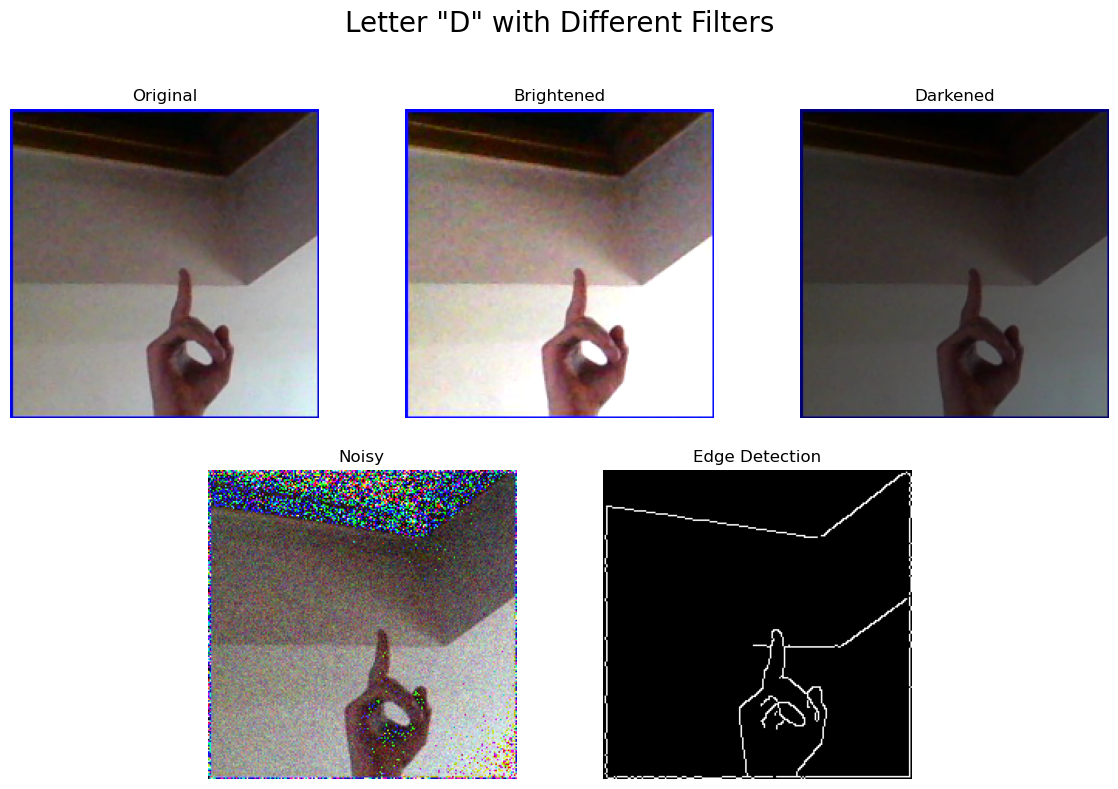

In [265]:
#randomly select letter from the dataset
letter = random.choice(asl_keep)

#grabs a random image from the selected letter
img_row = train_asl_df[train_asl_df['letter_label'] == letter].sample(1).iloc[0]
#gets the file path of the selected images
img_path = img_row['image_path']

#loads the image
img = plt.imread(img_path)

#sets up the figure and grid
fig = plt.figure(figsize=(12, 8))
#main title
fig.suptitle(f"Letter \"{letter}\" with Different Filters", fontsize=20)

#creates a 2 row 3 column grid
grid = plt.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

#subplots for the first row
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[0, 2])

#subplots for the second row
ax4 = fig.add_subplot(grid[1, 0:2])  #spans columns 0 and 1
ax5 = fig.add_subplot(grid[1, 1:3])  #spans columns 1 and 2

#first row first column will show the original image
ax1.imshow(img)
ax1.set_title("Original")

#first row second column will show a brightened image
bright_img = np.clip(img * 1.5, 0, 255).astype(np.uint8) #increase the brightness by multipling the pixel values
ax2.imshow(bright_img)
ax2.set_title("Brightened")

#first row third column will show a darkened image
dark_img = np.clip(img * 0.5, 0, 255).astype(np.uint8) #decrease the brightness by multipling pixel values
ax3.imshow(dark_img)
ax3.set_title("Darkened")

#second row first column/second column will show a noisy image
noisy_img = img.copy()
noise = np.random.normal(0, 20, img.shape).astype(np.uint8) #generates random Gaussian noise 
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8) #adds noise and clips values to keep within range 
ax4.imshow(noisy_img)
ax4.set_title("Noisy")

#second row second column/third column will show edge detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #converts to grayscale
edges = cv2.Canny(gray, 100, 200) #applies canny edge detection
ax5.imshow(edges, cmap='gray')
ax5.set_title("Edge Detection")

#hides the axes for all subplots
all_axes = [ax1, ax2, ax3, ax4, ax5]
for ax in all_axes:
    ax.axis('off')

#adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
#display plots
plt.show()

-----
###K-Means Clustering
- Before going into supervised learning, we will apply K-means clustering to find patterns
- This will help us:
    - Discover groupings in letters
    - Find similar letters that might be difficult to distinguish in the future
    - Understand the structure of our dataset

In [267]:
#how many images to sample per letter
sample_size_per_class = 50 
#empty df to store the images
sampled_df = pd.DataFrame()

for letter in asl_keep:
    #filters the dataset to get only images of the current letter
    letter_df = train_asl_df[train_asl_df['letter_label'] == letter]
    #randomly selects the specificed number of images for this letter
    letter_sample = letter_df.sample(min(sample_size_per_class, len(letter_df)))
    #adds the sampled images to the main df
    sampled_df = pd.concat([sampled_df, letter_sample])

#resets the index after sampling
sampled_df = sampled_df.reset_index(drop=True)

#list to store image arrays
X_sample = []
for img_path in sampled_df['image_path']:
    #reads the image from the file path
    img = cv2.imread(img_path)
    #resizes the image to 64 x 64
    img_resized = cv2.resize(img, (64, 64))
    #adds the processed image the the list
    X_sample.append(img_resized)

#convers the list into a numpy array
X_sample = np.array(X_sample)
#extracts the letter labels
y_sample = sampled_df['letter_label'].values

#flattens the images into 1D arrays 
X = X_sample.reshape(len(X_sample), -1)
#normalizes pixel values to be between 0 and 1
X = X.astype(float) / 255.  

#prints the shape of the processed image array
print("Array Shape:", X.shape)
print(f"Number of Features per Image: {X.shape[1]}")

Array Shape: (900, 12288)
Number of Features per Image: 12288


In [ ]:
#initialize k-means clustering with the number of ASL letters as clusters
#sets a number of inits
#fixes the state to reproduce
kmeans = KMeans(n_clusters=18, n_init=50, random_state=42)
#fits the k-means model to the image data
kmeans.fit(X)

#gets the cluster labels assigned to each image
kmeans_labs = kmeans.labels_
#computs the distance of each image to each cluster
X_distance = kmeans.transform(X)

#finds the index of the closest image to each cluster center
rep_letter_index = np.argmin(X_distance, axis=0)

#selects the representative images for each cluster
X_rep_letters = X_sample[rep_letter_index]
#gets the corresponding letter labels for those representative images  
y_rep_letters = y_sample[rep_letter_index]

#calculates and prints the silhouette score
print("Silhouette Score:", silhouette_score(X, kmeans_labs))

In [ ]:
#number of groups
n_groups = 18
#calculates the number of rows needed
rows = int(np.ceil(n_groups / 5))
#no more than 5 columns, or fewer if there are fewer group
cols = min(5, 18)

#creates a grid of subplots
fig1, ax1 = plt.subplots(rows, cols, figsize=(14, rows * 3), dpi=50)
#flattens the axes array
ax1 = ax1.flatten()

for i in range(n_groups):
    #displays the image for this cluster 
    im = ax1[i].imshow(X_rep_letters[i])
    #gets the corresponding letter label
    lab = y_rep_letters[i]
    #sets the title of the image to its ASL letter 
    ax1[i].set_title(f"{lab}", fontsize=15)
    #hides axis markings
    ax1[i].axis('off')

for j in range(n_groups, len(ax1)):
    ax1[j].axis('off')
    #turns off any extra unused subplots 

#prints before showing the images
print("K-Means Centroid ASL Letter Images:\n")
#adjusts layout to prevent overlap
plt.tight_layout()
#displays plot
plt.show()

In [ ]:
#sets the number of components
n_components = 2
#initializes PCA for reduction
pca = PCA(n_components=n_components)
#applies PCA and transforms the original data into 2D
X_pca = pca.fit_transform(X)

#color list
letter_colormap = ['red', 'gold', 'darkred', 'yellow', 'orange', 'greenyellow', 
                  'peru', 'purple', 'deeppink', 'blue', 'cyan', 'magenta',
                  'brown', 'olive', 'navy', 'teal', 'coral', 'silver']


if len(letter_colormap) < len(asl_keep):
    #if not enough colors, generate a new colormap dynamically 
    letter_colormap = plt.cm.tab20(np.linspace(0, 1, len(asl_keep)))

#gets the unique ASL letters in the dataset  
unique_letters = list(set(y_sample))
#creates a dataframe to map each letter to a color  
color_mapping = pd.DataFrame({
    'color': letter_colormap[:len(unique_letters)],
    'letter_label': unique_letters
})

#list to store colors for representative letters  
pca_colormap = []
for letter in y_rep_letters:
    #finds the color assigned to the current letter
    assigned_color = color_mapping[color_mapping['letter_label'] == letter].iloc[0, 0]
    #adds it to the color list 
    pca_colormap.append(assigned_color)

#figure size for the plot
plt.figure(figsize=(14, 8))

#plots the PCA-transformed data points, colored by cluster
for i in range(n_groups):
    plt.scatter(
        X_pca[kmeans_labs == i, 0],
        X_pca[kmeans_labs == i, 1],
        label=f'CL {i}, Mostly {y_sample[rep_letter_index[i]]}s',
        color=pca_colormap[i]
    )

#adds a legend showing cluster labels and their dominant letter
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
#sets the title for the plot
plt.title(f'K-Means Clustering with PCA Dimensionality Reduction\nfor Clusters 0 through {n_groups-1}',
          fontsize=15)
#labels the x axis 
plt.xlabel('Principal Component 1', fontsize=15)
#labels the y axis
plt.ylabel('Principal Component 2', fontsize=15)
#adds a grid
plt.grid(True, linestyle='--', alpha=0.7)
#displays plot
plt.show()

In [ ]:
#function for letter distrubution in two clusters
def plot_cluster_results(cluster_num_1, cluster_num_2):
    #creates a df with letter labels  
    sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample})
    #adds the assigned k-means cluster label
    sample_data_kmeans_labs['kmeans_lab'] = kmeans_labs

    #gets the count of each letter in cluster 1 
    cluster_1_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_1]['letter_label'].value_counts()

    #sets up a plot for the two clusters  
    fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=60)

    #list to store colors for cluster 1 
    pie_1_colors = []
    for letter in cluster_1_values.index:
        #assigns the color for this letter 
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_1_colors.append(color_row.iloc[0, 0])
        else:
            #assigns gray if no color is found
            pie_1_colors.append('gray')

    #creates a pie chart for cluster 1 
    axs[0].pie(cluster_1_values.values, labels=cluster_1_values.index, 
               autopct='%1.1f%%', colors=pie_1_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})

    #sets the title for cluster 1 pie chart
    axs[0].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_1}, Centroid of \'{y_sample[rep_letter_index[cluster_num_1]]}\'',
                     fontsize=18)

    #gets the count of each letter in cluster 2 
    cluster_2_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_2]['letter_label'].value_counts()

    #list to store colors for cluster 2
    pie_2_colors = []
    for letter in cluster_2_values.index:
        #assigns the color for this letter
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_2_colors.append(color_row.iloc[0, 0])
        else:
            #assigns gray if no color is found
            pie_2_colors.append('gray')

    #creates a pie chart for cluster 2  
    axs[1].pie(cluster_2_values.values, labels=cluster_2_values.index, 
               autopct='%1.1f%%', colors=pie_2_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})

    # sets the title for cluster 2
    axs[1].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_2}, Centroid of \'{y_sample[rep_letter_index[cluster_num_2]]}\'',
                     fontsize=18)

    #adjusts layout to prevent overlap 
    plt.tight_layout
    #displays the plot  
    plt.show()

#calls function for the 2 clusters
plot_cluster_results(0, 1)
plot_cluster_results(2, 3)
plot_cluster_results(4, 5)

In [ ]:
#function for visual from a specific cluster
def plot_cluster_images(cluster_num):
    #gets the indices of all images assigned to this cluster
    cluster_indices = np.where(kmeans_labs == cluster_num)[0]

    #limits the number of images displayed to 81 max  
    num_images = min(81, len(cluster_indices))
    #calculates the number of rows and columns
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    #creates the plot and flattens the axes array 
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8), dpi=70)
    ax = ax.flatten()

    #gets the most letter for this cluster
    centroid_letter = y_sample[rep_letter_index[cluster_num]]

    #sets the title with cluster info and the centroid letter 
    fig.suptitle(f"{num_images}/{len(cluster_indices)} Images from Cluster {cluster_num}, Centroid of \'{centroid_letter}\'", 
                 fontsize=19, y=0.94)

    #displays each image and removes axis markings 
    for i in range(num_images):
        ax[i].imshow(X_sample[cluster_indices[i]])
        ax[i].axis('off')

    #hides any extra subplots if there are fewer images than slots 
    for i in range(num_images, len(ax)):
        ax[i].axis('off')

    #adjusts the layout to prevent overlap with the title  
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #shows the final image grid
    plt.show()

#creates a df linking images to their cluster
sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample, 'kmeans_lab': kmeans_labs})

#dict to store purity scores for each cluster
cluster_purity = {}
for cluster in range(n_groups):
    #gets the letter labels of all images in the cluster 
    cluster_letters = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster]['letter_label']
    if len(cluster_letters) > 0:
        #finds the most common letter in the cluster
        most_common_letter = cluster_letters.value_counts().idxmax()
        #calc purity as the fraction of the dominant letter in the cluster
        purity = cluster_letters.value_counts().max() / len(cluster_letters)
        #stores the cluster's purity score
        cluster_purity[cluster] = purity

#sorts clusters by purity in descending order
sorted_clusters = sorted(cluster_purity.items(), key=lambda x: x[1], reverse=True)

#gets the cluster with the highest purity 
high_purity_cluster = sorted_clusters[0][0]
#gets the cluster with the lowest purity 
low_purity_cluster = sorted_clusters[-1][0]

#prints info about the highest purity cluster 
print(f"High purity cluster {high_purity_cluster} (purity: {sorted_clusters[0][1]:.2f})")
#plots images from the highest purity cluster
plot_cluster_images(high_purity_cluster)

In [ ]:
#prints info about the lowest purity cluster 
print(f"Low purity cluster {low_purity_cluster} (purity: {sorted_clusters[-1][1]:.2f})")
#plots images from the lowest purity cluster
plot_cluster_images(low_purity_cluster)

In [ ]:
#calls plot_cluster_result function for the 2 clusters
plot_cluster_results(high_purity_cluster, low_purity_cluster)

###K-Means Observations
- A silhouette score of ~0.16 means the clusters are somewhat separated—not great, but not terrible either. That makes sense for something like ASL hand signs, where a lot of letters look pretty similar in shape and positioning.
- Some clusters are much more "pure" than others. However, almost every ASL letter shows up in a cluster to some degree. "A" shares a lot of visual features with other letters, making it hard to separate cleanly using unsupervised clustering.

In [ ]:
#function to load, split, and preprocess the dataset
def load_and_preprocess_dataset(train_asl_df, asl_keep, image_size=(64, 64)):
    #empty dataframe to store ASL letters 
    train_df_balanced = pd.DataFrame()
    
    for letter in asl_keep:
        #collects all images for the selected letters
        letter_df = train_asl_df[train_asl_df['letter_label'] == letter]
        train_df_balanced = pd.concat([train_df_balanced, letter_df])

    #resets the index after filtering
    train_df_balanced = train_df_balanced.reset_index(drop=True)

    #Splitting data into training, validation, and test sets
    #first split- 70% for training and 30% into a temp set  
    train_df, temp_df = train_test_split(
        train_df_balanced, 
        test_size=0.3, 
        random_state=42,
        stratify=train_df_balanced['letter_label']
    )

    #second split: divides the temp set equally into validation and test sets
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df['letter_label']
    )

    #resets index for after splitting
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    #function to load and resize images 
    def load_images(df):
        X = []
        for img_path in df['image_path']:
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, image_size)
            X.append(img_resized)
        return np.array(X)

    #loads and resizes images for each dataset split
    X_train = load_images(train_df)
    X_val = load_images(val_df)
    X_test = load_images(test_df)

    #grabs the letter labels  
    y_train = train_df['letter_label'].values
    y_val = val_df['letter_label'].values
    y_test = test_df['letter_label'].values

    #label encoder to convert letters into numerical values
    label_encoder = LabelEncoder()

    #encodes the labels into numeric values
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    #creates a df mapping letters to their encoded values
    encoded_dict = pd.DataFrame({
        'letter_label': label_encoder.classes_,
        'encoded_label': np.arange(len(label_encoder.classes_))
    })

    #prints out dataset size and class info
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")


    #returns processed data and label mappings
    return (X_train, y_train, y_train_encoded, 
            X_val, y_val, y_val_encoded, 
            X_test, y_test, y_test_encoded, 
            encoded_dict)